## Example Notebook
This notebook will guide you through the main phases of the analysis. 

Please note you need the access to the Analitix cluster.


In [ ]:
import compUtils as cu
from sklearn import metrics


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
spark=spark

In [4]:
date='2020/11/09'
pd.set_option('display.max_colwidth', -1)


Read the error messages from HDFS using spark. A Pandas dataframe is returned.

In [5]:
df=cu.readData(date,spark)


In [ ]:
df

Install `clusterlogs` package and import `pipeline`. `Pipeline` is the workflow module.

`Pipeline.chain` vectorizes the error messages and clusters them (default=DBSCAN):
- `mode='process'` : uses a pre-trained Word2Vec model (`new_model_NUCLEUS.model`).
- `tf_idf=True` : defines the weighting factor for the sentence vectorization (see [this page](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)).
- `clean_short=True` : cleans short words (2 characters long) except for "no".
- `min_freq=False` : if True, removes words occuring only once.

Different clustering algorithm can be accessed by setting `algorithm='hdbscan'` or `algorithm='hierarchical'`.

In [6]:
!pip install clusterlogs
from clusterlogs import pipeline

In [19]:
clusterML=pipeline.Chain(df, target='error_message', mode='process',clustering_type='ML',model_name='training_study/modelmin_count2_default_cleanshortTrue/new_model_NUCLEUS.model',tf_idf=True,clean_short=True,min_freq=False)#7 window

In [20]:
clusterML.process()

Found 651 equal groups
Vectorization of tokens finished
Vectorization of sentences is finished
K-neighbours = 26
DBSCAN finished with 19 clusters and 0 noise points
--- 180.00391149520874 seconds ---


# Cluster Plot

Estimated number of clusters: 19
Estimated number of noise points: 0


Text(0.5, 1.0, 'Estimated number of clusters: 19')

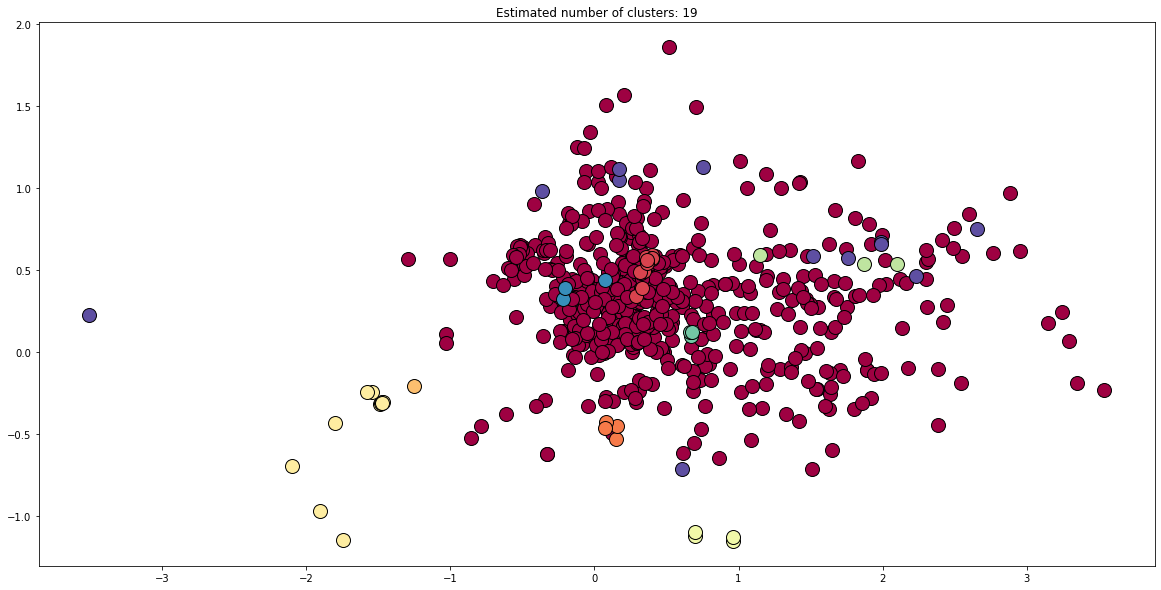

In [23]:
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
labels = clusterML.clusters.cluster_labels
X=clusterML.vectors.sent2vec
core_samples_mask = np.zeros_like(clusterML.clusters.cluster_labels, dtype=bool)
core_samples_mask[clusterML.clusters.db.core_sample_indices_] = True
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 2, len(unique_labels))]
plt.figure(figsize=(20,10)) 
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
# plt.show()


Through `clusterML.result` you can access the clusters and the information about them.

In [24]:
clusterML.result[["cluster_size",'cleaned_pattern']].iloc[:10]

cluster_size  \
0   404467         
11  32245          
9   7081           
6   4751           
4   2018           
7   592            
10  455            
15  168            
8   64             
2   45             

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

Export to `csv`.

In [11]:
clusterML.result[['cluster_size','indices','cleaned_pattern','silhouette_coef']].to_csv('comparison/ML11nov2020.csv')


# Similarity clustering
Let's set `clean_short=False` and cluster by similarity (default option). The similarity is computed as Levenshtein distance (see [here](https://en.wikipedia.org/wiki/Levenshtein_distance)).

In [10]:
clusterSIM=pipeline.Chain(df, target='error_message',min_freq=True,clean_short=False)
clusterSIM.process()

Found 538 equal groups
Finished with 403 clusters
--- 258.88165736198425 seconds ---


In [12]:
clusterSIM.result[['cluster_size','cleaned_pattern','indices']][:11]

,cluster_size,cleaned_pattern,indices
105,328069,"[cgsi gsoap running on reports error reading token data header connection reset by peer, cgsi gsoap running on reports error reading token data header connection closed]","[67, 101, 103, 121, 514, 528, 577, 592, 605, 740, 778, 883, 897, 946, 952, 966, 980, 991, 993, 1013, 1016, 1033, 1110, 1165, 1182, 1218, 1269, 1279, 1289, 1293, 1424, 1432, 1494, 1589, 1620, 1623, 1628, 1630, 1634, 1646, 1741, 1742, 1771, 1888, 1889, 1896, 1919, 2006, 2030, 2051, 2060, 2093, 2118, 2156, 2164, 2185, 2204, 2220, 2262, 2386, 2404, 2931, 2964, 3199, 3300, 3329, 3342, 3343, 3364, 3393, 3397, 3411, 3551, 3554, 3646, 4051, 4058, 4079, 4139, 4161, 4296, 4336, 4625, 4639, 4644, 4647, 4689, 4757, 4759, 4888, 5004, 5115, 5151, 5232, 5251, 5422, 5484, 6088, 6326, 6656, ...]"
304,35205,[source the source file is not online],"[36, 46, 131, 170, 194, 201, 213, 220, 223, 228, 238, 253, 257, 258, 259, 261, 295, 296, 342, 354, 360, 370, 389, 393, 403, 404, 425, 430, 432, 467, 478, 518, 530, 550, 554, 556, 557, 558, 561, 571, 580, 602, 603, 609, 611, 615, 631, 633, 638, 648, 664, 723, 726, 779, 783, 847, 849, 874, 922, 955, 963, 1059, 1066, 1091, 1211, 1339, 1415, 1690, 1764, 1839, 1859, 1900, 1970, 2036, 2146, 2315, 2317, 2335, 2413, 2421, 2430, 2433, 2541, 2543, 2544, 2549, 2572, 2578, 2608, 2609, 2610, 2613, 2614, 2617, 2618, 2621, 2638, 2640, 2647, 2648, ...]"
380,33806,"[an end file was reached an end of file occurred, transfer an end file was reached an end of file occurred]","[5257, 8598, 16703, 16706, 16718, 16821, 16825, 18199, 18202, 20867, 28702, 29079, 29082, 29112, 29233, 29243, 31628, 31630, 34041, 34042, 34055, 34827, 34899, 34909, 34915, 34917, 35184, 35653, 35704, 35774, 35788, 35811, 36217, 44107, 44212, 44311, 44417, 44511, 44571, 44573, 44579, 45308, 45335, 47074, 48787, 48788, 51730, 51763, 52766, 52832, 52866, 52936, 53033, 53051, 53052, 53086, 56246, 56270, 56322, 56324, 60949, 61331, 61337, 64964, 69766, 69769, 69770, 69771, 69788, 69838, 72105, 72106, 72108, 73586, 73700, 73829, 74787, 79317, 79343, 79352, 79363, 79381, 81720, 81721, 87279, 91870, 91993, 92007, 92286, 92297, 92365, 92396, 92439, 93019, 93026, 93039, 93047, 93108, 93151, 93160, ...]"
158,28672,[error reported from no such file or directory],"[53, 231, 243, 508, 687, 753, 809, 884, 1054, 1213, 1214, 1215, 1216, 1353, 1354, 1355, 1356, 1785, 2044, 2216, 2219, 2357, 2588, 3094, 3096, 3102, 3304, 3366, 3367, 3479, 3480, 4475, 4645, 5094, 5098, 5295, 5298, 5430, 5431, 5432, 5606, 6026, 6077, 6078, 6082, 6083, 6084, 6087, 6107, 6141, 6142, 6143, 6157, 6160, 6180, 6181, 6182, 6184, 6186, 6187, 6218, 6221, 6256, 6371, 6373, 6375, 6376, 6377, 6378, 6379, 6400, 6407, 6444, 6446, 6447, 6448, 6449, 6450, 6467, 6469, 6498, 6501, 6502, 6504, 6538, 6539, 6580, 6602, 6642, 6691, 6693, 6694, 6696, 6697, 6699, 6700, 6701, 6702, 6703, 6732, ...]"
357,19040,[invalid surl],"[3, 9, 11, 12, 18, 20, 40, 48, 50, 51, 60, 64, 71, 81, 104, 108, 229, 234, 236, 246, 254, 275, 287, 305, 325, 326, 329, 332, 339, 341, 345, 392, 405, 406, 450, 451, 465, 480, 489, 492, 496, 501, 523, 532, 533, 560, 568, 585, 591, 601, 607, 654, 659, 685, 692, 699, 707, 713, 714, 735, 738, 744, 752, 758, 760, 767, 773, 796, 803, 805, 807, 808, 813, 845, 856, 859, 861, 862, 880, 889, 896, 929, 944, 974, 976, 983, 989, 990, 995, 1002, 1003, 1004, 1007, 1020, 1023, 1029, 1031, 1035, 1038, 1044, ...]"
217,17837,"[ssl handshake failed connection timed out during ssl handshake after attempts, ssl handshake failed connection timed out during ssl handshake]","[0, 1, 27, 28, 29, 92, 94, 95, 111, 114, 150, 151, 188, 209, 210, 230, 280, 320, 349, 390, 469, 555, 678, 680, 750, 801, 864, 866, 877, 915, 937, 938, 971, 1009, 1018, 1036, 1037, 1064, 1150, 1160, 1161, 1175, 1186, 1187, 1188, 1189, 1197, 1209, 1249, 1256, 1266, 1274, 1280, 1296, 1425, 1472, 1479, 1492, 1493, 1504, 1515, 1522, 1581, 1582, 1595, 1611, 1613, 1624, 1655, 1667, 1681, 1692, 1699, 1728, 1763, 1769, 1801, 1811, 186

In [53]:
clusterSIM.result.head(1)

,cluster_size,common_phrases_RAKE,indices,pattern,sequence,tokenized_pattern,vec
54,328069,[cgsi gsoap running reports reading token data header connection closed],"[67, 101, 103, 121, 514, 528, 577, 592, 605, 740, 778, 883, 897, 946, 952, 966, 980, 991, 993, 1013, 1016, 1033, 1110, 1165, 1182, 1218, 1269, 1279, 1289, 1293, 1424, 1432, 1494, 1589, 1620, 1623, 1628, 1630, 1634, 1646, 1741, 1742, 1771, 1888, 1889, 1896, 1919, 2006, 2030, 2051, 2060, 2093, 2118, 2156, 2164, 2185, 2204, 2220, 2262, 2386, 2404, 2931, 2964, 3199, 3300, 3329, 3342, 3343, 3364, 3393, 3397, 3411, 3551, 3554, 3646, 4051, 4058, 4079, 4139, 4161, 4296, 4336, 4625, 4639, 4644, 4647, 4689, 4757, 4759, 4888, 5004, 5115, 5151, 5232, 5251, 5422, 5484, 6088, 6326, 6656, ...]","[srm-ifce err: Communication error on send, err: CGSI-gSOAP running on reports Error reading]","[cgsi, gsoap, running, reports, reading, token, data, header, connection]","[srm-ifce, ▁, err:, ▁, Communication, ▁, error, ▁, on, ▁, send,, ▁, err:, ▁, ▁, ▁, CGSI-gSOAP, ▁, running, ▁, on, ▁, ▁, reports, ▁, Error, ▁, reading]","0 False 1 False 2 False 3 False 4 False 5 False 6 False 7 False 9 False 10 False 11 False 12 False 13 False 14 False 15 False 16 False 18 False 19 False 20 False 22 False 23 False 24 False 25 False 26 False 27 False 28 False 29 False 30 False 32 False 33 False ... 476 False 477 False 478 False 479 False 481 False 482 False 483 False 486 False 487 False 488 False 489 False 491 False 492 False 493 False 497 False 499 False 500 False 501 False 502 False 504 False 505 False 508 False 511 False 512 False 514 False 515 False 520 False 522 False 524 False 527 False Name: ratio, Length: 405, dtype: bool"


In [17]:
cluster.result[['cluster_size' ,'error_category', 'indices','cleaned_pattern']]

cluster_size  \
37   328069         
6    77368          
48   35539          
94   28674          
39   20296          
134  19040          
154  17837          
189  15303          
76   14231          
10   12810          
26   12294          
87   12044          
96   10748          
178  10597          
83   9932           
31   9651           
25   8627           
19   8157           
4    7689           
3    7262           
18   5264           
170  3713           
46   3553           
216  2465           
88   2346           
22   1476           
30   1427           
103  1312           
117  1237           
8    1090           
..    ...           
137  2              
158  2              
144  2              
85   2              
128  2              
121  2              
93   2              
168  2              
150  1              
123  1              
217  1              
124  1              
125  1              
114  1              
143  1              
211  1              
164  1              
157  1              
208  1              
159  1              
58   1              
34   1              
92   1              
199  1              
174  1              
86   1              
80   1              
194  1              
181  1              
133  1              

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

# Hierarchical clustering

In [ ]:
clusterML = pipeline.Chain(df, target='error_message',algorithm='hierarchical', mode='process',clustering_type='ML',model_name='training_study/model_tuning/up7Nov_default.model')
clusterML.process()

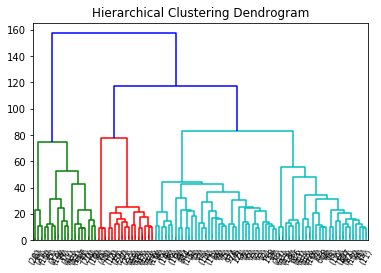

In [10]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage


X=clusterML.clusters.vectors.sent2vec
linkage_matrix = linkage(X, 'ward')
dendrogram(
    linkage_matrix,
    truncate_mode="lastp",  # show only the last p merged clusters
    p=100,  # show only the last p merged clusters
    show_leaf_counts=True,  # numbers in brackets are counts, others idx
    leaf_rotation=60.,
    leaf_font_size=8.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()